# Pets dataset

In [ ]:
import pandas as pd
import seaborn as sns
from tensorflow import keras

In [ ]:
# Download the images
!wget https://myslu.stlawu.edu/~ltorrey/ml/pets.zip
!unzip -q pets.zip

--2024-04-09 18:30:45--  https://myslu.stlawu.edu/~ltorrey/ml/pets.zip
Resolving myslu.stlawu.edu (myslu.stlawu.edu)... 69.6.96.96
Connecting to myslu.stlawu.edu (myslu.stlawu.edu)|69.6.96.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113522782 (108M) [application/zip]
Saving to: ‘pets.zip’

pets.zip            100%[===================>] 108.26M  51.6MB/s    in 2.1s    

2024-04-09 18:30:48 (51.6 MB/s) - ‘pets.zip’ saved [113522782/113522782]



In [ ]:
# Use directories as datasets
train = keras.utils.image_dataset_from_directory("pets/train", image_size=(256, 256), color_mode="rgb", batch_size=32)
test = keras.utils.image_dataset_from_directory("pets/test", image_size=(256, 256), color_mode="rgb", batch_size=32)
val = keras.utils.image_dataset_from_directory("pets/val", image_size=(256, 256), color_mode="rgb", batch_size=32)

Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


# Baseline model

In [ ]:
# Design a traditional convnet
baseline = keras.models.Sequential([
    keras.Input(shape=(256, 256, 3)),
    keras.layers.Rescaling(1/255),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
# Train the network
stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
baseline.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
history = baseline.fit(train, epochs=100, validation_data=val, callbacks=[stopping], verbose=False)

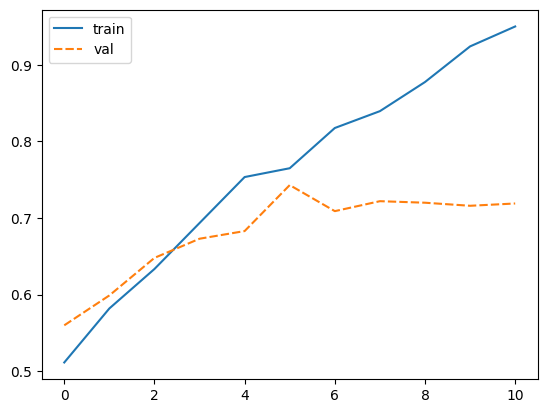

In [ ]:
# Plot the learning curve
curve = pd.DataFrame({"train": history.history["accuracy"], "val": history.history["val_accuracy"]})
plot = sns.lineplot(data=curve)

In [ ]:
# Evaluate on the test data
baseline.evaluate(test)

63/63 [==============================] - 3s 43ms/step - loss: 0.6238 - accuracy: 0.6935


[0.6238420009613037, 0.6934999823570251]

# Augmented model

In [ ]:
# Design a network that augments the images
augmented = keras.models.Sequential([
    keras.Input(shape=(256, 256, 3)),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2),
    keras.layers.Rescaling(1/255),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
# Train the network
stopping = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
augmented.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
history = augmented.fit(train, epochs=100, validation_data=val, callbacks=[stopping], verbose=False)

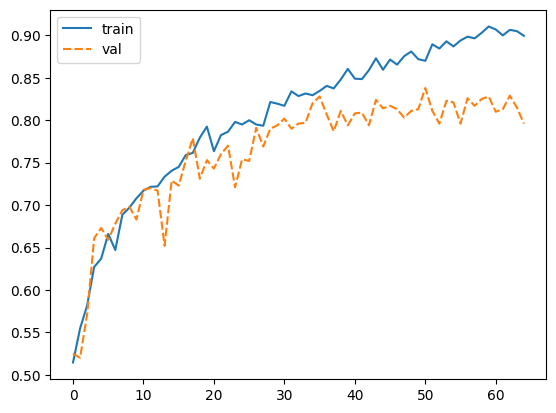

In [ ]:
# Plot the learning curve
curve = pd.DataFrame({"train": history.history["accuracy"], "val": history.history["val_accuracy"]})
plot = sns.lineplot(data=curve)

In [ ]:
# Evaluate on the test data
augmented.evaluate(test)

63/63 [==============================] - 3s 49ms/step - loss: 0.4482 - accuracy: 0.8130


[0.4482369124889374, 0.8130000233650208]

# Pretrained model

In [ ]:
# Load a pretrained convolutional base
base = keras.applications.EfficientNetB0(weights="imagenet", input_shape=(256, 256, 3), include_top=False)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Freeze the pretrained weights
base.trainable = False

In [ ]:
# Design a network around the pretrained base
pretrained = keras.models.Sequential([
    keras.Input(shape=(256, 256, 3)),
    keras.layers.Lambda(keras.applications.efficientnet.preprocess_input),
    base,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
# Train the network
stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
pretrained.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
history = pretrained.fit(train, epochs=100, validation_data=val, callbacks=[stopping], verbose=False)

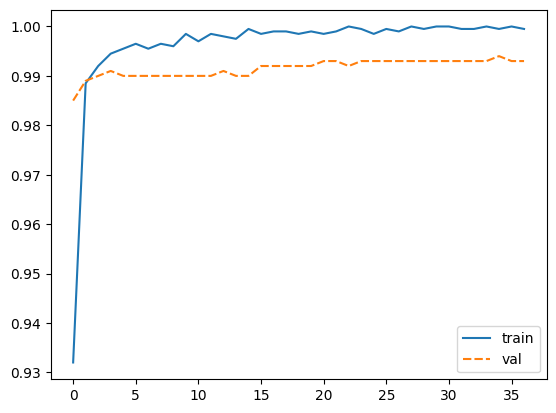

In [ ]:
# Plot the learning curve
curve = pd.DataFrame({"train": history.history["accuracy"], "val": history.history["val_accuracy"]})
plot = sns.lineplot(data=curve)

In [ ]:
# Evaluate on the test data
pretrained.evaluate(test)

63/63 [==============================] - 7s 99ms/step - loss: 0.0163 - accuracy: 0.9955


[0.01634821482002735, 0.9955000281333923]